 # Применение алгоритма k ближайших соседей для предсказания типа ДТП

 Сначала напишем самую тривиальную модель, которая по широте и долготе ДТП предсказывает тип ДТП.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import json
from collections import Counter
number = 300

In [0]:
def open_file(file_name):
    with open(file_name + '.json', 'r') as f:
        data = json.loads(f.read())
    return pd.DataFrame(data)

In [22]:
df2016 = open_file('2016')
df2017 = open_file('2017')
df2016.head()

,reg_code,reg_name,road_code,road_name,road_type,oktmo,address,crash_type_name,crash_date,crash_time,crash_reason,fatalities_amount,victims_amount,vehicles_amount,participants_amount,latitude,longitude
0,38,Курская область,М-2,"""Крым"" Москва - Тула - Орел - Курск - Белгород...",Федеральная дорога общего пользования,38620000,"ЦФО, Курская область, Курский район",Столкновение,20170101,02:55,Другие нарушения ПДД водителями,0,1,2,2,51.845189,36.092892
1,53,Оренбургская область,53К-0801000,Бузулук - Грачевка,Региональная или межмуниципальная дорога общег...,53612000,"ПФО, Оренбургская область, Бузулукский район",Наезд на пешехода,20170101,02:55,Ходьба вдоль проезжей части попутного направле...,0,1,1,2,52.7947,52.3261
2,81,Республика Бурятия,,,Тип дороги не определен,,"Республика Бурятия, г Улан-Удэ, ул Борсоева, 109а",Наезд на стоящее ТС,20170101,02:55,,1,0,4,4,51.8631,107.5394
3,60,Ростовская область,,,Тип дороги не определен,60615436101,"Ростовская область, х Кавалерский, ул Ленина, 47",Наезд на препятствие,20170101,02:50,,1,0,1,1,46.1342,40.0836
4,63,Саратовская область,,,Тип дороги не определен,,"Саратовская область, г Саратов, ул Симбирская,...",Наезд на препятствие,20170101,02:50,,0,2,1,2,51.5506,46.0408


In [0]:
def convert_types_into_nums(y):
    c = Counter()
    for i in y:
        c[i] += 1
    ##print(c)
    t = list(c)
    d = {}
    for i, v in enumerate(t):
        d[v] = i
    Y = []
    for i in y:
        Y.append(d[i])
    return Y

In [0]:
def convert_crash_time(arr): ##02:25
    for i in range(len(arr)):
        h1 = int(arr[i][0])
        h2 = int(arr[i][1])
        m1 = int(arr[i][3])
        m2 = int(arr[i][4])
        ans = (h1 * 10 + h2) * 60  + (m1 * 10 + m2)
        ##ans = (h1 * 10 + h2)
        arr[i] = ans
    return arr

In [0]:
def convert_crash_date(arr): ##year + month + day 20170701
    for i in range(len(arr)):
        m1 = int(arr[i][4])
        m2 = int(arr[i][5])
        d1 = int(arr[i][6])
        d2 = int(arr[i][7])
        ans = (m1 * 10 + m2 - 1) * 30 + (d1 * 10 + d2)
        ##ans = (m1 * 10 + m2)
        arr[i] = ans
    return arr

In [0]:
def get_region(df, region):
    res = dict()
    cnt = 0
    for i in range(df.shape[0]):
        if df.iloc[i]['reg_name'] == region:
            res[cnt] = df.iloc[i]
            cnt += 1
    ans = pd.DataFrame(res)
    ans = ans.T
    ans['fatalities_amount'] = ans['fatalities_amount'].astype(int)
    ans['victims_amount'] = ans['victims_amount'].astype(int)
    ans['vehicles_amount'] = ans['vehicles_amount'].astype(int)
    ans['participants_amount'] = ans['participants_amount'].astype(int)
    ##print(ans['crash_time'])
    ans['crash_time'] = convert_crash_time(ans['crash_time'])
    ans['crash_date'] = convert_crash_date(ans['crash_date'])
    return ans

In [0]:
def prepare_very_simple_model(df, number):
    X = df.drop(columns=['reg_code', 'reg_name', 'road_code', 'road_name', 'road_type',
                         'oktmo', 'address', 'crash_type_name', 'crash_date', 'crash_time',
                         'crash_reason', 'fatalities_amount', 'victims_amount', 'vehicles_amount',
                         'participants_amount'])
    y = convert_types_into_nums(df['crash_type_name'])
    scores = []
    for k in range(1, number):
        knn = KNeighborsClassifier(n_neighbors=k)
        ans = cross_val_score(knn, X, y, cv=5)
        scores.append(ans.mean())
    scores = np.array(scores)
    
    return scores

In [0]:
def make_datasets_and_check(region, number):
    myDf2016 = get_region(df2016, region)
    myDf2017 = get_region(df2017, region)
    scores2016 = prepare_very_simple_model(myDf2016, number)
    scores2017 = prepare_very_simple_model(myDf2017, number)
    return scores2016, scores2017

In [0]:
def draw_graphics(scores2016, scores2017):
    plt.plot(range(1, len(scores2016) + 1), scores2016, label='2016')
    plt.plot(range(1, len(scores2016) + 1), scores2017, label='2017')
    plt.legend()
    plt.grid()
    plt.show()

In [0]:
scores2016_msk, scores2017_msk = make_datasets_and_check('Москва', number)

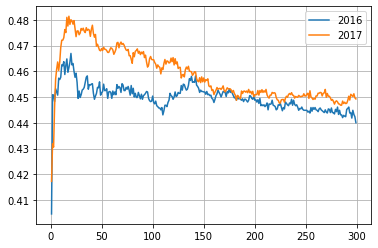

In [31]:
draw_graphics(scores2016_msk, scores2017_msk)

In [0]:
scores2016_spb, scores2017_spb = make_datasets_and_check('Санкт-Петербург', number)

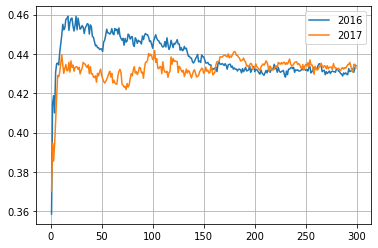

In [33]:
draw_graphics(scores2016_spb, scores2017_spb)

# Попробуем посмотреть на результат без кросс-валидации.

In [0]:
def prepare_very_simple_model_no_crossvalidation(df, number):
    X = df.drop(columns=['reg_code', 'reg_name', 'road_code', 'road_name', 'road_type',
                         'oktmo', 'address', 'crash_type_name', 'crash_date', 'crash_time',
                         'crash_reason', 'fatalities_amount', 'victims_amount', 'vehicles_amount',
                         'participants_amount'])
    y = convert_types_into_nums(df['crash_type_name'])
    scores = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)
    for k in range(1, number):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_test_pred = knn.predict(X_test)
        ans = accuracy_score(y_test, y_test_pred)
        scores.append(ans.mean())
    scores = np.array(scores)
    
    return scores

In [0]:
region = 'Москва'
myDf2016 = get_region(df2016, region)
myDf2017 = get_region(df2017, region)

In [0]:
scores2016_no_crossval = prepare_very_simple_model_no_crossvalidation(myDf2016, number)

In [0]:
scores2017_no_crossval = prepare_very_simple_model_no_crossvalidation(myDf2017, number)

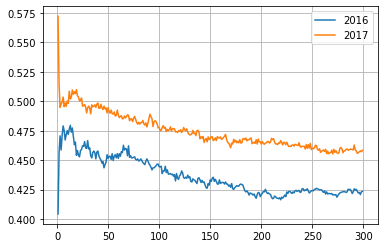

In [38]:
plt.plot(range(1, len(scores2016_no_crossval) + 1), scores2016_no_crossval, label='2016')
plt.plot(range(1, len(scores2016_no_crossval) + 1), scores2017_no_crossval, label='2017')
plt.legend()
plt.grid()
plt.show()

Ничего, особо, не поменялось. Скачок графика в 0.575 можно объяснить только удачей в разбиении выборки.

Промежуточный вывод: доля правильных ответов низка на всех данных. Попробуем улучшить модель.

# Применим kNN с весами

In [0]:
def prepare_simple_model(df, number):
    X = df.drop(columns=['reg_code', 'reg_name', 'road_code', 'road_name', 'road_type',
                         'oktmo', 'address', 'crash_type_name', 'crash_date', 'crash_time',
                         'crash_reason', 'fatalities_amount', 'victims_amount', 'vehicles_amount',
                         'participants_amount'])
    y = convert_types_into_nums(df['crash_type_name'])
    scores = []
    for k in range(1, number):
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        ans = cross_val_score(knn, X, y, cv=5)
        scores.append(ans.mean())
    scores = np.array(scores)
    
    return scores

In [0]:
def make_datasets_and_check2(region, number):
    myDf2016 = get_region(df2016, region)
    myDf2017 = get_region(df2017, region)
    scores2016 = prepare_simple_model(myDf2016, number)
    scores2017 = prepare_simple_model(myDf2017, number)
    return scores2016, scores2017

In [0]:
def draw_graphics2(scores2016, scores2017):
    plt.plot(range(1, len(scores2016) + 1), scores2016, label='2016')
    plt.plot(range(1, len(scores2016) + 1), scores2017, label='2017')
    plt.legend()
    plt.grid()
    plt.show()

In [0]:
scores2016_msk2, scores2017_msk2 = make_datasets_and_check2('Москва', number)

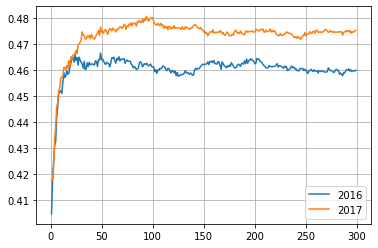

In [43]:
draw_graphics2(scores2016_msk2, scores2017_msk2)

In [0]:
scores2016_spb2, scores2017_spb2 = make_datasets_and_check2('Санкт-Петербург', number)

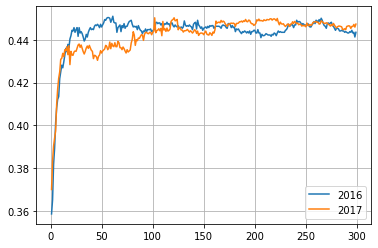

In [45]:
draw_graphics2(scores2016_spb2, scores2017_spb2)

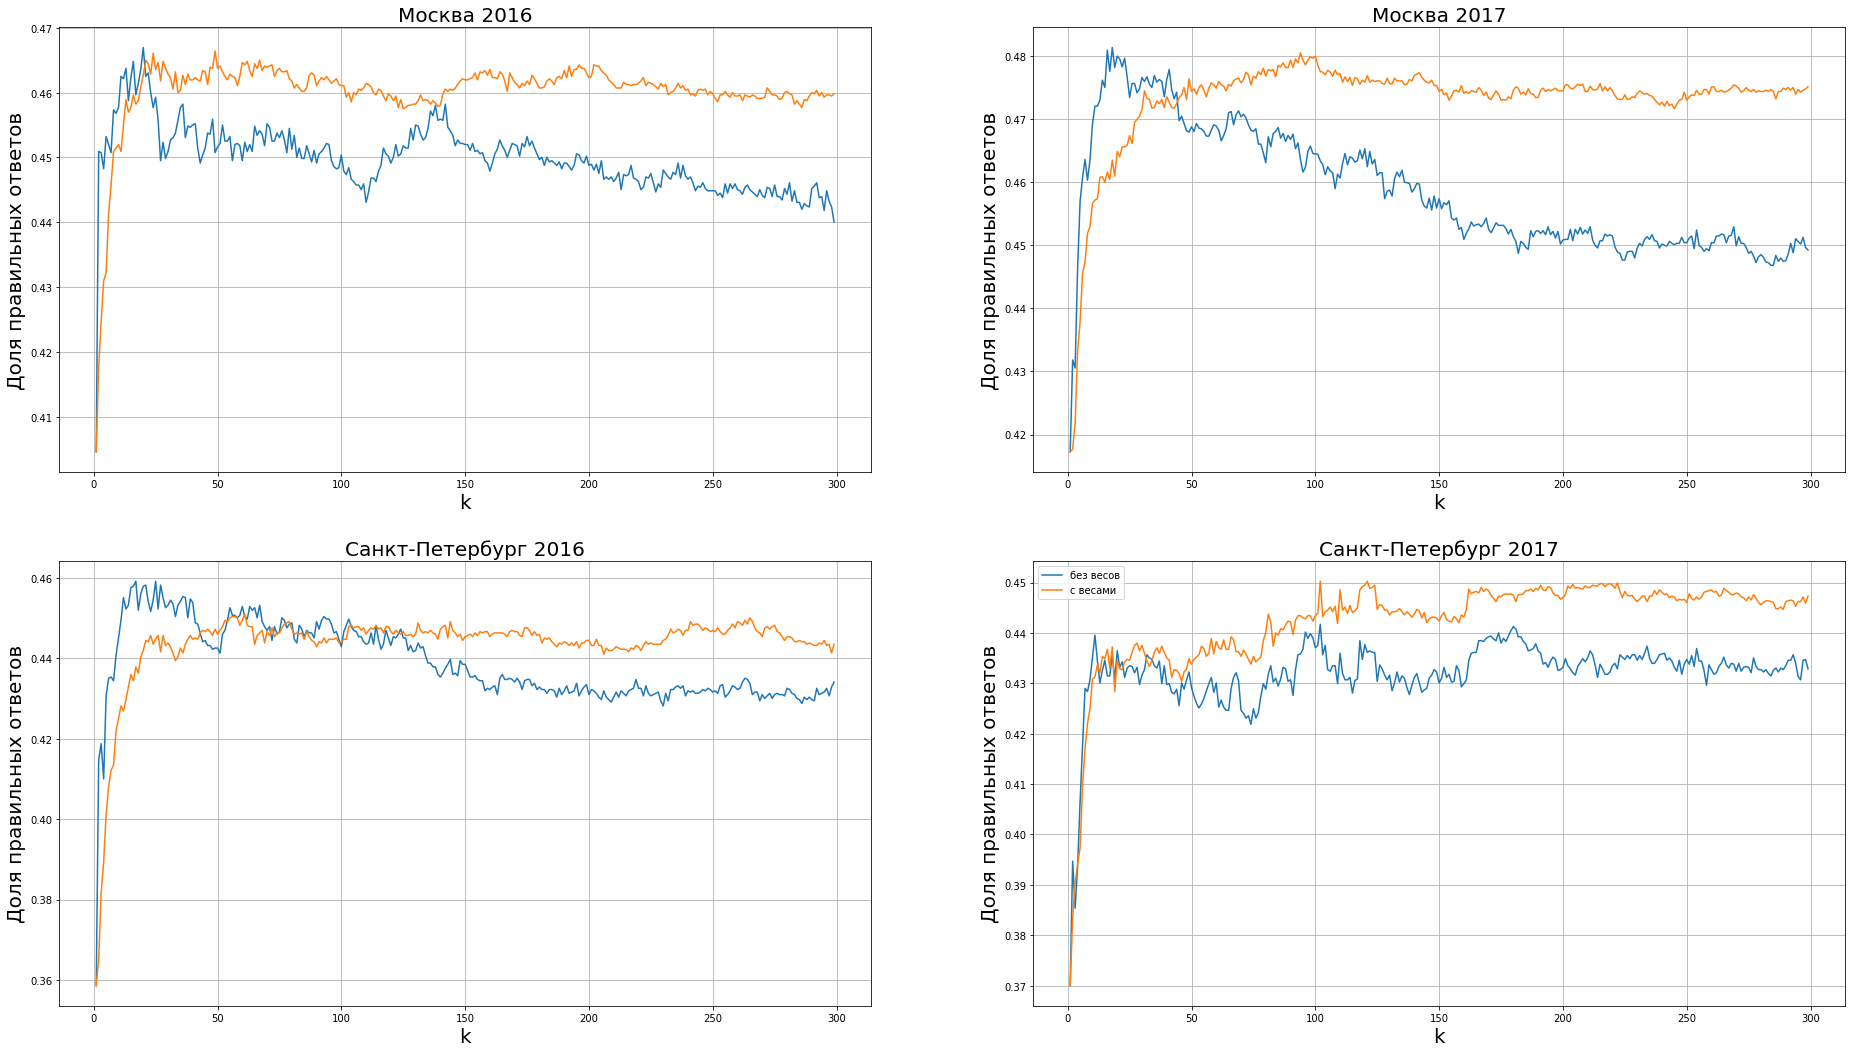

In [46]:
x_vals = range(1, len(scores2016_msk) + 1)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (32, 18))
axes[0][0].plot(x_vals, scores2016_msk)
axes[0][0].plot(x_vals, scores2016_msk2)
axes[0][0].grid()
axes[0][0].set_xlabel('k', fontsize=20)
axes[0][0].set_ylabel('Доля правильных ответов', fontsize=20)
axes[0][0].set_title('Москва 2016', fontsize=20)

axes[0][1].plot(x_vals, scores2017_msk)
axes[0][1].plot(x_vals, scores2017_msk2)
axes[0][1].grid()
axes[0][1].set_xlabel('k', fontsize=20)
axes[0][1].set_ylabel('Доля правильных ответов', fontsize=20)
axes[0][1].set_title('Москва 2017', fontsize=20)

axes[1][0].plot(x_vals, scores2016_spb)
axes[1][0].plot(x_vals, scores2016_spb2)
axes[1][0].grid()
axes[1][0].set_xlabel('k', fontsize=20)
axes[1][0].set_ylabel('Доля правильных ответов', fontsize=20)
axes[1][0].set_title('Санкт-Петербург 2016', fontsize=20)

axes[1][1].plot(x_vals, scores2017_spb, label='без весов')
axes[1][1].plot(x_vals, scores2017_spb2, label='с весами')
axes[1][1].grid()
axes[1][1].legend()
axes[1][1].set_xlabel('k', fontsize=20)
axes[1][1].set_ylabel('Доля правильных ответов', fontsize=20)
axes[1][1].set_title('Санкт-Петербург 2017', fontsize=20)

fig.show()
fig.savefig("Сравнение kNN без весов и с весами", dpi=300)

# Вывод по данной модели

kNN с весами имеет более высокую долю правильных ответов, однако всё равно она слишком мала для реального применения.

Одна из причин такой доли правильных ответов -- сам датасет. Проведя первичный анализ и отобразив метки на карте, можно уверенно заявить: данные очень плохие.

Кроме того, как вы можете заметить, очень неравномерно распределены типы ДТП. Из-за этого тоже падает точность. 

Попробуем разбить наш датасет на две части: данные о самых популярных типах ДТП (столкновение и наезд на пешехода) и о менее популярных, но частых (наезд на препятствие/стоящее ТС/велосипедиста, падение пассажира и опрокидывание.

# Разобьём датасет и заново обучим нашу модель

На этот раз сразу будем пользоваться kNN'ом с весами



In [0]:
myDf2016 = get_region(df2016, 'Москва')

In [0]:
def get_major_and_minor_accidents(df):
    minor_types = ['Падение пассажира', 'Опрокидывание', 'Наезд на стоящее ТС', 'Наезд на препятствие', 'Наезд на велосипедиста']
    major_types = ['Столкновение', 'Наезд на пешехода']
    new_minor_df = pd.DataFrame(columns=df.columns)
    new_major_df = pd.DataFrame(columns=df.columns)
    ##print(df.iloc[0].values)
    for i in range(df.shape[0]):
        cur_type = df.iloc[i]['crash_type_name']
        ##print(df.iloc[i].values)
        for j in minor_types:
            if j == cur_type:
                new_minor_df.loc[new_minor_df.shape[0]] = df.iloc[i].values
        for j in major_types:
            if j == cur_type:
                new_major_df.loc[new_major_df.shape[0]] = df.iloc[i].values
    
    return new_minor_df, new_major_df

In [0]:
def make_datasets_and_check3(region, number):
    myDf2016 = get_region(df2016, region)
    my_minor_df2016, my_major_df2016 = get_major_and_minor_accidents(myDf2016)
    myDf2017 = get_region(df2017, region)
    my_minor_df2017, my_major_df2017 = get_major_and_minor_accidents(myDf2017)
    scores2016_minor = prepare_simple_model(my_minor_df2016, number)
    scores2016_major = prepare_simple_model(my_major_df2016, number)

    scores2017_minor = prepare_simple_model(my_minor_df2017, number)
    scores2017_major = prepare_simple_model(my_major_df2017, number)
    return scores2016_minor, scores2016_major, scores2017_minor, scores2017_major
    ##return scores2016_minor, scores2016_major

In [0]:
def draw_graphics3(scores_minor, scores_major):
    plt.plot(range(1, len(scores_minor) + 1), scores_minor, label='minor')
    plt.plot(range(1, len(scores_major) + 1), scores_major, label='major')
    plt.legend()
    plt.grid()
    plt.show()

In [0]:
scores2016_minor_msk, scores2016_major_msk, scores2017_minor_msk, scores2017_major_msk = make_datasets_and_check3('Москва', number)

In [52]:
print(scores2016_minor_msk.max(), scores2016_major_msk.max())

0.344954128440367 0.6037819799777531


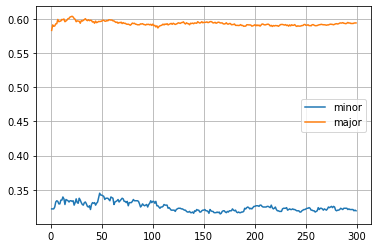

In [53]:
draw_graphics3(scores2016_minor_msk, scores2016_major_msk)

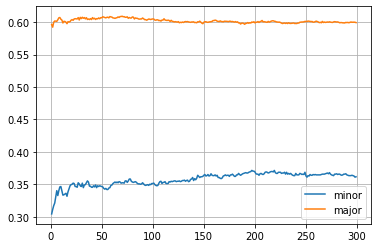

In [54]:
draw_graphics3(scores2017_minor_msk, scores2017_major_msk)

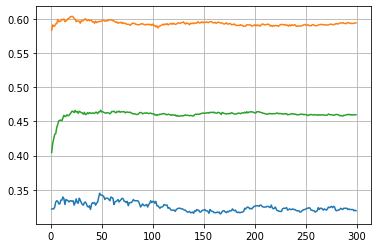

In [55]:
plt.plot(range(1, len(scores2016_minor_msk) + 1), scores2016_minor_msk, label='minor')
plt.plot(range(1, len(scores2016_major_msk) + 1), scores2016_major_msk, label='major')
plt.plot(range(1, len(scores2016_msk2) + 1), scores2016_msk2, label='both')
##plt.legend()
plt.grid()
plt.show()

In [0]:
scores2016_minor_spb, scores2016_major_spb, scores2017_minor_spb, scores2017_major_spb = make_datasets_and_check3('Санкт-Петербург', number)

0.3952306138480529 0.5986272473550984


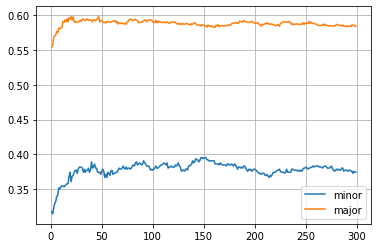

In [57]:
print(scores2016_minor_spb.max(), scores2016_major_spb.max())
draw_graphics3(scores2016_minor_spb, scores2016_major_spb)

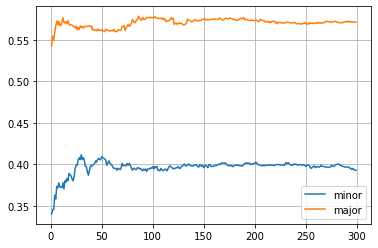

In [58]:
draw_graphics3(scores2017_minor_spb, scores2017_major_spb)

Получается, что разделение на major и minor типы не даёт разительного преимущества. Да, у major поднимается доля правильных ответов (на k~= 0.12), но на такую же величину, в среднем, падает доля правильных ответов у minor. 
Сделаем последний тест -- соединим датасеты за разные годы в один, разобьём на major и minor и посмотрим на результаты. 

# Объединённые за несколько лет датасеты

In [0]:
def unite_data_sets(df1, df2):
    return pd.concat([df1, df2], ignore_index=True)

In [0]:
myDf2016 = get_region(df2016, 'Москва')
myDf2017 = get_region(df2017, 'Москва')
myDfMoscow = unite_data_sets(myDf2016, myDf2017)
myDfMoscow

In [0]:
new_minor_df_Moscow, new_major_df_Moscow = get_major_and_minor_accidents(myDfMoscow)

In [0]:
scores_minor_msk = prepare_simple_model(new_minor_df_Moscow, number)
scores_major_msk = prepare_simple_model(new_major_df_Moscow, number)

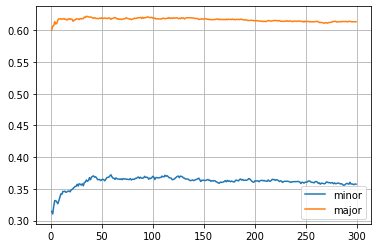

In [63]:
draw_graphics3(scores_minor_msk, scores_major_msk)

In [64]:
print(scores_minor_msk.max(), scores_major_msk.max())

0.37224027814519484 0.6222348749107665


# Окончательные выводы по первоначальной модели

1. Датасет действительно не очень хорош
2. Наша модель не подходит для предсказания типа ДТП. Одна из возможных причин -- гипотеза компактности не работает для данных объектов.
3. Можно ли изменить модель -- нет. Изменение модели -- добавление параметров объектов, например даты или времени суток. Однако совершенно не ясно, как тогда вводить метрику расстояния между объектами и как считать веса объектов. Кроме того, это увеличивает число параметров, которые должен вводить пользователь, а это нарушает изначальную концепцию данной фичи.

Изменение самой модели и применение других методов машинного обучения для предсказания типа ДТП -- одна из перспектив дальнейшей разработки.

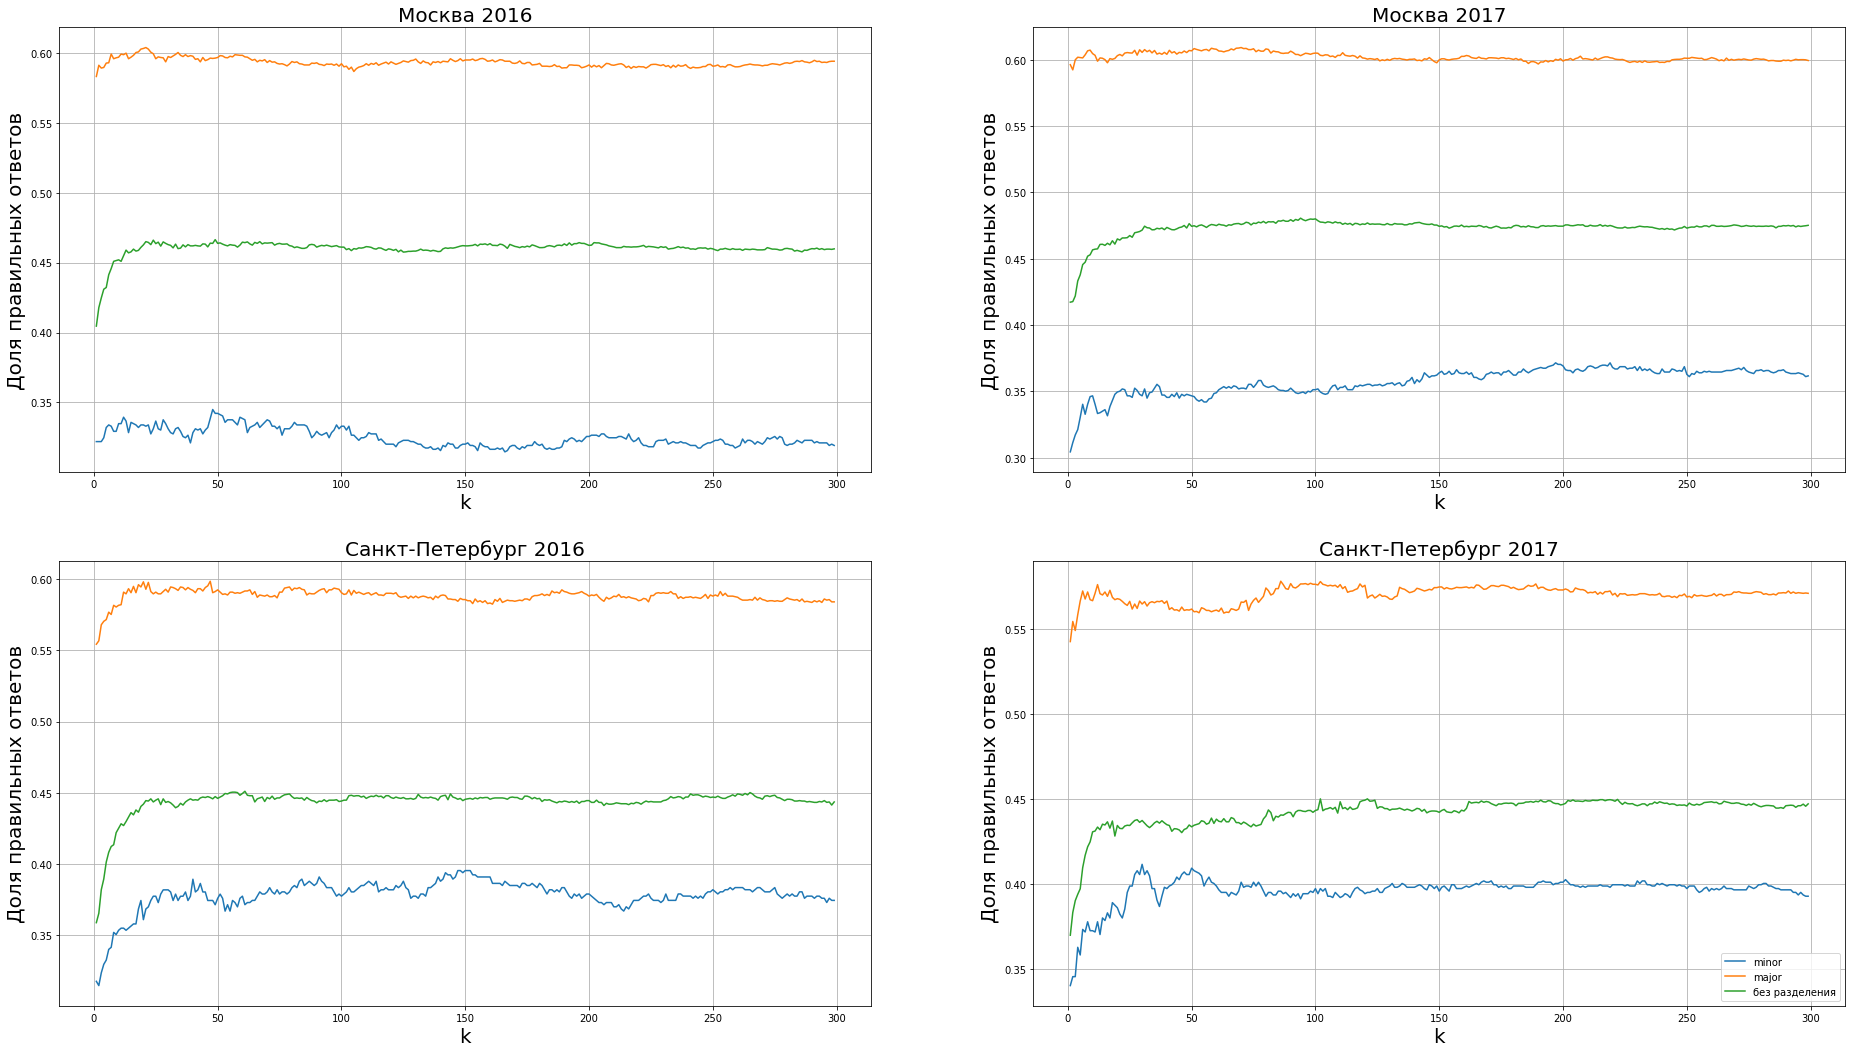

In [65]:
## есть график по minor, major, both и alldata + major/minor
x_vals = range(1, len(scores2016_msk) + 1)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (32, 18))
axes[0][0].plot(x_vals, scores2016_minor_msk, label='minor')
axes[0][0].plot(x_vals, scores2016_major_msk, label='major')
axes[0][0].plot(x_vals, scores2016_msk2, label='без разделения')
axes[0][0].grid()
##axes[0][0].legend()
axes[0][0].set_xlabel('k', fontsize=20)
axes[0][0].set_ylabel('Доля правильных ответов', fontsize=20)
axes[0][0].set_title('Москва 2016', fontsize=20)

axes[0][1].plot(x_vals, scores2017_minor_msk, label='minor')
axes[0][1].plot(x_vals, scores2017_major_msk, label='major')
axes[0][1].plot(x_vals, scores2017_msk2, label='без разделения')
axes[0][1].grid()
##axes[0][1].legend()
axes[0][1].set_xlabel('k', fontsize=20)
axes[0][1].set_ylabel('Доля правильных ответов', fontsize=20)
axes[0][1].set_title('Москва 2017', fontsize=20)

axes[1][0].plot(x_vals, scores2016_minor_spb, label='minor')
axes[1][0].plot(x_vals, scores2016_major_spb, label='major')
axes[1][0].plot(x_vals, scores2016_spb2, label='без разделения')
axes[1][0].grid()
##axes[1][0].legend()
axes[1][0].set_xlabel('k', fontsize=20)
axes[1][0].set_ylabel('Доля правильных ответов', fontsize=20)
axes[1][0].set_title('Санкт-Петербург 2016', fontsize=20)

axes[1][1].plot(x_vals, scores2017_minor_spb, label='minor')
axes[1][1].plot(x_vals, scores2017_major_spb, label='major')
axes[1][1].plot(x_vals, scores2017_spb2, label='без разделения')
axes[1][1].grid()
axes[1][1].legend()
axes[1][1].set_xlabel('k', fontsize=20)
axes[1][1].set_ylabel('Доля правильных ответов', fontsize=20)
axes[1][1].set_title('Санкт-Петербург 2017', fontsize=20)

fig.show()
fig.savefig("Окончательное сравнение моделей kNN", dpi=300)

# P. S. Попробуем изменить концепцию алгоритма
Добавим внутренние признаки ДТП (число пострадавших, число жертв, количество участников, количество транспорта) в модель.

In [0]:
myDf2016 = get_region(df2016, 'Москва')
myDf2017 = get_region(df2017, 'Москва')
myDf = unite_data_sets(myDf2016, myDf2017)

In [67]:
myDf.head()

,reg_code,reg_name,road_code,road_name,road_type,oktmo,address,crash_type_name,crash_date,crash_time,crash_reason,fatalities_amount,victims_amount,vehicles_amount,participants_amount,latitude,longitude
0,45,Москва,,,Тип дороги не определен,,Москва,Столкновение,1,155,,1,0,2,3,55.345925,37.343014
1,45,Москва,,,Тип дороги не определен,,"Москва, п Матвеевское, пер Очаковский 1-й, 9",Наезд на пешехода,1,30,,1,0,1,2,55.4058,37.2734
2,45,Москва,,Московская кольцевая автомобильная дорога (МКА...,Региональная или межмуниципальная дорога общег...,45368000,"Москва,район Митино,МКАД, 68-й километр, внешн...",Столкновение,361,1370,Нарушение правил перестроения,1,0,2,3,55.8323,37.3952
3,45,Москва,,,Тип дороги не определен,,"Москва, г Москва, ш Энтузиастов, 40",Столкновение,361,1370,,2,0,2,3,55.757595,37.74802
4,45,Москва,М-3,"""Украина"" Москва - Калуга - Брянск - граница с...",Федеральная дорога общего пользования,45941000,"Москва,Гагаринский район,Университетский проспект",Столкновение,361,1350,Неправильный выбор дистанции,1,0,2,2,55.6988,37.5488


In [0]:
def prepare_new_model(df, number):
    scaler = MinMaxScaler()
    
    X = df.drop(columns=['reg_code', 'reg_name', 'road_code', 'road_name', 'road_type',
                         'oktmo', 'address', 'crash_type_name', 'crash_date', 'crash_time',
                         'crash_reason'])
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    y = convert_types_into_nums(df['crash_type_name'])
    scores = []
    for k in range(1, number):
        knn = KNeighborsClassifier(n_neighbors=k)
        ans = cross_val_score(knn, X_scaled, y, cv=5)
        scores.append(ans.mean())
    scores = np.array(scores)
    
    return scores

In [0]:
tmp = prepare_new_model(myDf, 100)

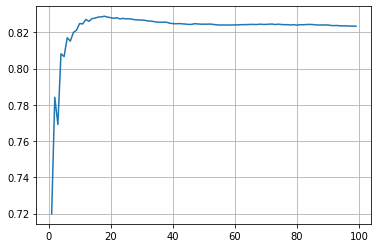

In [70]:
plt.plot(range(1, len(tmp)+ 1), tmp)
plt.grid()
plt.show()

In [71]:
tmp.max()

0.8289220563847429

# Добавление внешних факторов
В уже имеющуюся модель добавим внешние факторы -- время и дату ДТП. Предварительно эти данные нужны привести к новому виду. Напомню, что в датасете время задаётся как строка (пример -- '02:35'), дата тоже задана строкой (пример -- '20161231').
Выразим время как число минут: '02:35' -> 155.
Выразим дату как число дней с начала года: '20160205' -> 36.

In [0]:
def prepare_new_model2(df, number):
    scaler = MinMaxScaler()
    
    X = df.drop(columns=['reg_code', 'reg_name', 'road_code', 'road_name', 'road_type',
                         'oktmo', 'address', 'crash_type_name', 'crash_reason'])
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    y = convert_types_into_nums(df['crash_type_name'])
    scores = []
    print(X_scaled.head())
    for k in range(1, number):
        knn = KNeighborsClassifier(n_neighbors=k)
        ans = cross_val_score(knn, X_scaled, y, cv=5)
        scores.append(ans.mean())
    scores = np.array(scores)
    
    return scores

In [0]:
tmp = prepare_new_model2(myDf, 100)

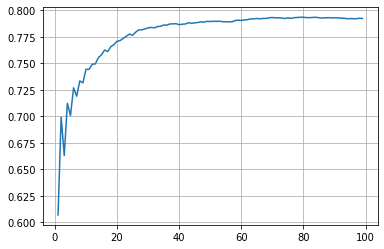

In [74]:
plt.plot(range(1, len(tmp)+ 1), tmp)
plt.grid()
plt.show()

In [75]:
tmp.max()

0.7933665008291875

# Посмотрим на зависимость только от внешних факторов

In [0]:
def prepare_new_model3(df, number):
    scaler = MinMaxScaler()
    
    X = df.drop(columns=['reg_code', 'reg_name', 'road_code', 'road_name', 'road_type',
                         'oktmo', 'address', 'crash_type_name',
                         'crash_reason', 'fatalities_amount', 'victims_amount', 'vehicles_amount',
                         'participants_amount'])
    
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    y = convert_types_into_nums(df['crash_type_name'])
    scores = []
    ##print(X_scaled.head())
    for k in range(1, number):
        knn = KNeighborsClassifier(n_neighbors=k)
        ans = cross_val_score(knn, X_scaled, y, cv=5)
        scores.append(ans.mean())
    scores = np.array(scores)
    
    return scores

In [0]:
tmp = prepare_new_model3(myDf, 100)

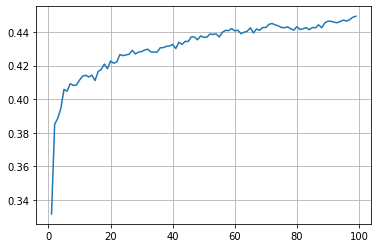

In [78]:
plt.plot(range(1, len(tmp)+ 1), tmp)
plt.grid()
plt.show()

In [0]:
def prepare_new_model4(df, number):
    scaler = MinMaxScaler()
    
    X = df.drop(columns=['reg_code', 'reg_name', 'road_code', 'road_name', 'road_type',
                         'oktmo', 'address', 'crash_type_name',
                         'crash_reason', 'fatalities_amount', 'victims_amount', 'vehicles_amount',
                         'participants_amount'])
    
    ##X_scaled = scaler.fit_transform(X)
    ##X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    y = convert_types_into_nums(df['crash_type_name'])
    scores = []
    ##print(X_scaled.head())
    for k in range(1, number):
        knn = KNeighborsClassifier(n_neighbors=k)
        ans = cross_val_score(knn, X, y, cv=5)
        scores.append(ans.mean())
    scores = np.array(scores)
    
    return scores

In [0]:
tmp = prepare_new_model4(myDf, 100)

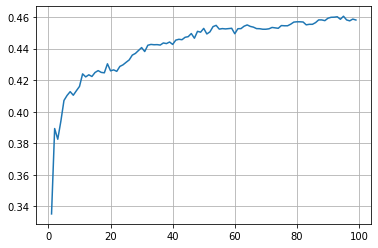

In [81]:
plt.plot(range(1, len(tmp)+ 1), tmp)
plt.grid()
plt.show()

# Более подробный обзор модели с внутренними признаками


In [0]:
def make_datasets_and_check4(region, number):
    myDf2016 = get_region(df2016, region)
    myDf2017 = get_region(df2017, region)
    myDf = unite_data_sets(myDf2016, myDf2017)
    scores2016 = prepare_new_model(myDf2016, number)
    scores2017 = prepare_new_model(myDf2017, number)
    scoresboth = prepare_new_model(myDf, number)

    return scores2016, scores2017, scoresboth

In [0]:
def draw_graph(scores2016, scores2017, scoresboth):
    x_args = range(1, len(scores2016) + 1)
    plt.plot(x_args, scores2016, label='2016')
    plt.plot(x_args, scores2017, label='2017')
    plt.plot(x_args, scoresboth, label='both')
    plt.grid()
    plt.legend()
    plt.show()

In [0]:
scores2016_newmodel_msk, scores2017_newmodel_msk, scoresboth_newmodel_msk = make_datasets_and_check4('Москва', 100)

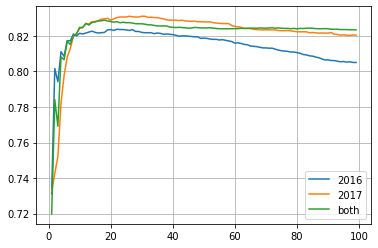

In [106]:
draw_graph(scores2016_newmodel_msk, scores2017_newmodel_msk, scoresboth_newmodel_msk)

In [107]:
print(scores2016_newmodel_msk.max(), scores2017_newmodel_msk.max(), scoresboth_newmodel_msk.max())

0.8238013152318322 0.8311139627580861 0.8289220563847429


In [0]:
scores2016_newmodel_spb, scores2017_newmodel_spb, scoresboth_newmodel_spb = make_datasets_and_check4('Санкт-Петербург', 100)

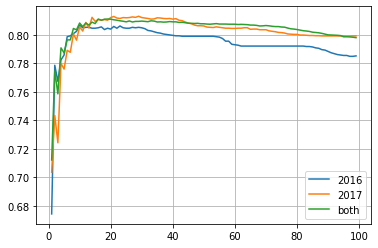

In [109]:
draw_graph(scores2016_newmodel_spb, scores2017_newmodel_spb, scoresboth_newmodel_spb)

In [110]:
print(scores2016_newmodel_spb.max(), scores2017_newmodel_spb.max(), scoresboth_newmodel_spb.max())

0.8067670390157033 0.8129757768793759 0.8110220668508441


## Cводная таблица по новой модели kNN

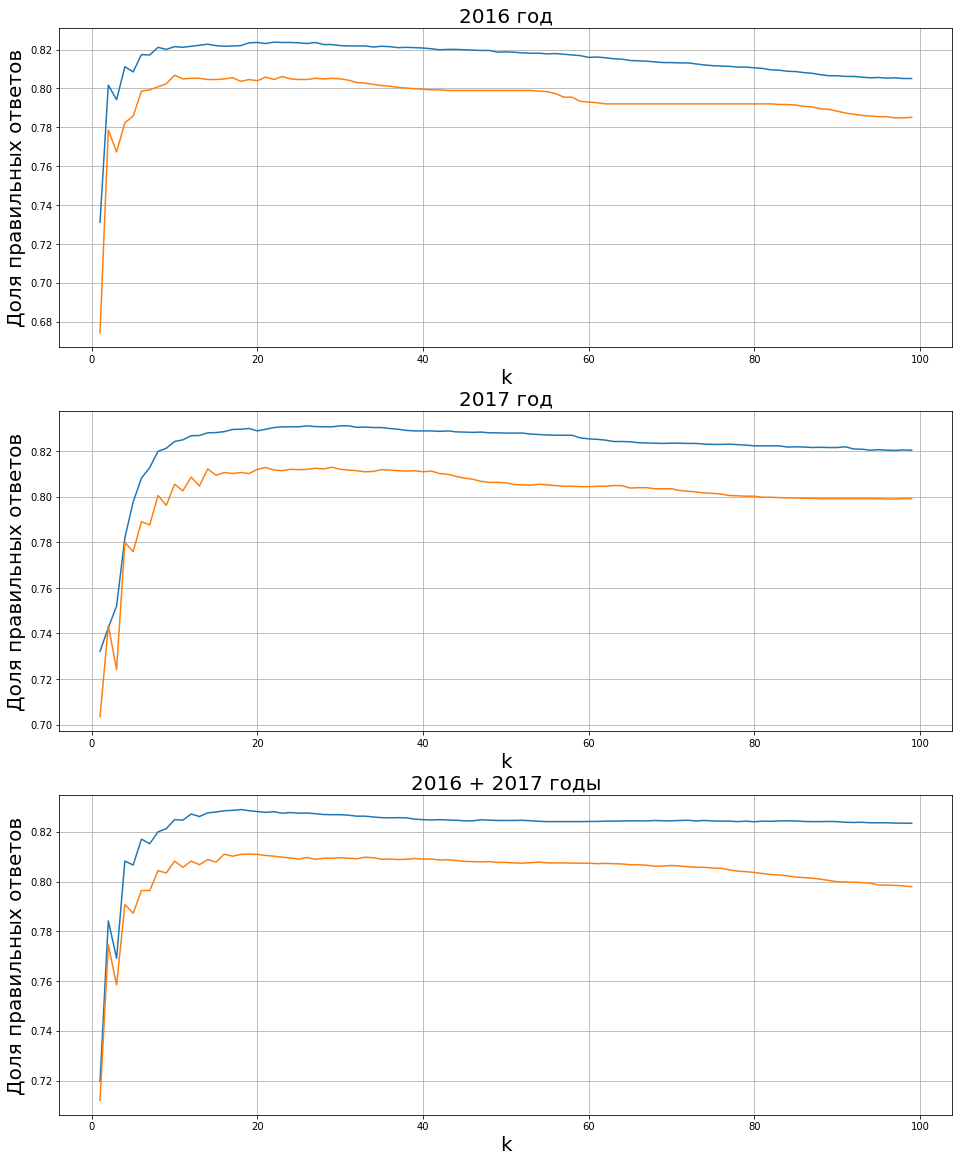

In [113]:
## есть график по minor, major, both и alldata + major/minor
x_vals = range(1, len(scores2016_newmodel_spb) + 1)
fig, axes = plt.subplots(nrows=3, figsize = (16, 20))
axes[0].plot(x_vals, scores2016_newmodel_msk, label='MSK')
axes[0].plot(x_vals, scores2016_newmodel_spb, label='SPB')
axes[0].grid()
##axes[0][0].legend()
axes[0].set_xlabel('k', fontsize=20)
axes[0].set_ylabel('Доля правильных ответов', fontsize=20)
axes[0].set_title('2016 год', fontsize=20)

axes[1].plot(x_vals, scores2017_newmodel_msk, label='MSK')
axes[1].plot(x_vals, scores2017_newmodel_spb, label='SPB')
axes[1].grid()
##axes[0][0].legend()
axes[1].set_xlabel('k', fontsize=20)
axes[1].set_ylabel('Доля правильных ответов', fontsize=20)
axes[1].set_title('2017 год', fontsize=20)

axes[2].plot(x_vals, scoresboth_newmodel_msk, label='MSK')
axes[2].plot(x_vals, scoresboth_newmodel_spb, label='SPB')
axes[2].grid()
##axes[0][0].legend()
axes[2].set_xlabel('k', fontsize=20)
axes[2].set_ylabel('Доля правильных ответов', fontsize=20)
axes[2].set_title('2016 + 2017 годы', fontsize=20)


fig.show()
fig.savefig("Accuracy новых моделей", dpi=300)